In [2]:
# Basic packages
import numpy as np
import time
import sys
import os
from pathlib import Path
import logging
import importlib
import mysql.connector

import pandas as pd
pd.set_option('display.max_columns', None)

# import warnings
# warnings.filterwarnings("ignore")

# Astropy packages
from astropy.table import Table
from astropy.io import fits

# Matplotlib packages
import matplotlib.pyplot as plt

# Scipy
import scipy
from scipy.optimize import curve_fit
from scipy import signal


import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore')


# Useful if working in SSH Vscode
working_directory = '/avatar/yanilach/PhD-Home/binaries_galah-main/spectrum_analysis/BinaryAnalysis'
os.chdir(working_directory)
import AnalysisFunctions as af
from stellarmodel import StellarModel



sys.path.append(os.path.join(working_directory, 'utils'))
import AstroPandas as ap

# Accepts mass, log(age), metallicity. Outputs Teff, logg, and log(L) bolometric (flux)
isochrone_table = Table.read(working_directory +  '/assets/parsec_isochrones_logt_8p00_0p01_10p17_mh_m2p75_0p25_m0p75_mh_m0p60_0p10_0p70_GaiaEDR3_2MASS.fits')
isochrone_interpolator = af.load_isochrones()

# Results from CCF
results_text = pd.read_csv("/avatar/yanilach/PhD-Home/binaries_galah-main/spectrum_analysis" + "/CCF_results.txt", sep='\t', names=["sobject_id", "no_peaks", "RVs"])
results_text['index'] = results_text.index

GALAH_DR4_dir = '/avatar/buder/GALAH_DR4/'
if 'GALAH_DR4' not in locals():
    GALAH_DR4 = ap.FitsToDF(GALAH_DR4_dir + "catalogs/galah_dr4_allspec_240207.fits")
    # GALAH_DR4 = ap.FitsToDF("/avatar/yanilach/PhD-Home/binaries_galah-main/catalogs/galah_dr4_allspec_240207.fits")
    


In [3]:
# Some obvious binary stars for testing.

if os.path.exists(working_directory + "obvious_binaries.csv"):
    obvious_binaries = pd.read_csv(working_directory + "obvious_binaries.csv")
else:
    obvious_binaries = []
    binary_stars = results_text[results_text['no_peaks'] == 2]
    for sobject_id in binary_stars['sobject_id']:
        dir = GALAH_DR4_dir + 'observations/' + str(sobject_id)[:6] + '/spectra/com/' + str(sobject_id) + '1.fits'
        if os.path.exists(dir):
            obvious_binaries.append(sobject_id)

    df = pd.DataFrame(obvious_binaries)
    df.to_csv(working_directory + "obvious_binaries.csv", index=False)

print(len(obvious_binaries))

3023


170614004601079


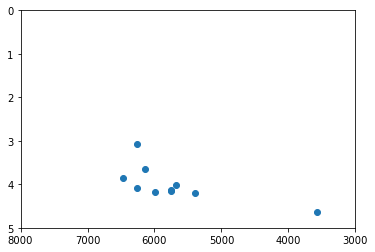

In [3]:


# Get all stars in GALAH DR4 where the sobject_id is in obvious_binaries array
binary_stars = GALAH_DR4[GALAH_DR4['sobject_id'].isin(obvious_binaries['0'].values)]
binary_stars

# Create a random selection of stars, covering the parameter space in teff and logg between 3000 and 8000 K, and 0 and 5 respectively
# This is to test the code with a variety of stars
random_stars = binary_stars.sample(10)
random_stars

plt.figure()
plt.scatter(random_stars['teff'], random_stars['logg'])
plt.xlim(3000, 8000)
plt.ylim(0, 5)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

print(random_stars['sobject_id'].values[0])

Succsefully found file for object /avatar/buder/GALAH_DR4/observations/131216/spectra/com/1312160011010261.fits
No LSF reported for CCD4. Replaced LSF and LSF-B for CCD 4 with profile from 131216002101026
fitting with rvs:  116.17699 38.0 131216001101026
Initial parameters:
{'f_contr': 0.5, 'mass_1': 0.888822, 'age_1': 11.125676155090332, 'metallicity_1': -0.34353057, 'rv_1': 116.17699, 'fe_h_1': -0.4178822, 'vmic_1': 1.5, 'vsini_1': 4.0, 'mass_2': 0.888822, 'age_2': 11.125676155090332, 'metallicity_2': -0.34353057, 'rv_2': 38.0, 'fe_h_2': -0.4178822, 'vmic_2': 1.5, 'vsini_2': 4.0, 'teff_1': 5.3533408203125, 'teff_2': 5.3533408203125, 'logg_1': 4.327199, 'logg_2': 4.327199, 'logl_1': 0, 'logl_2': 0}


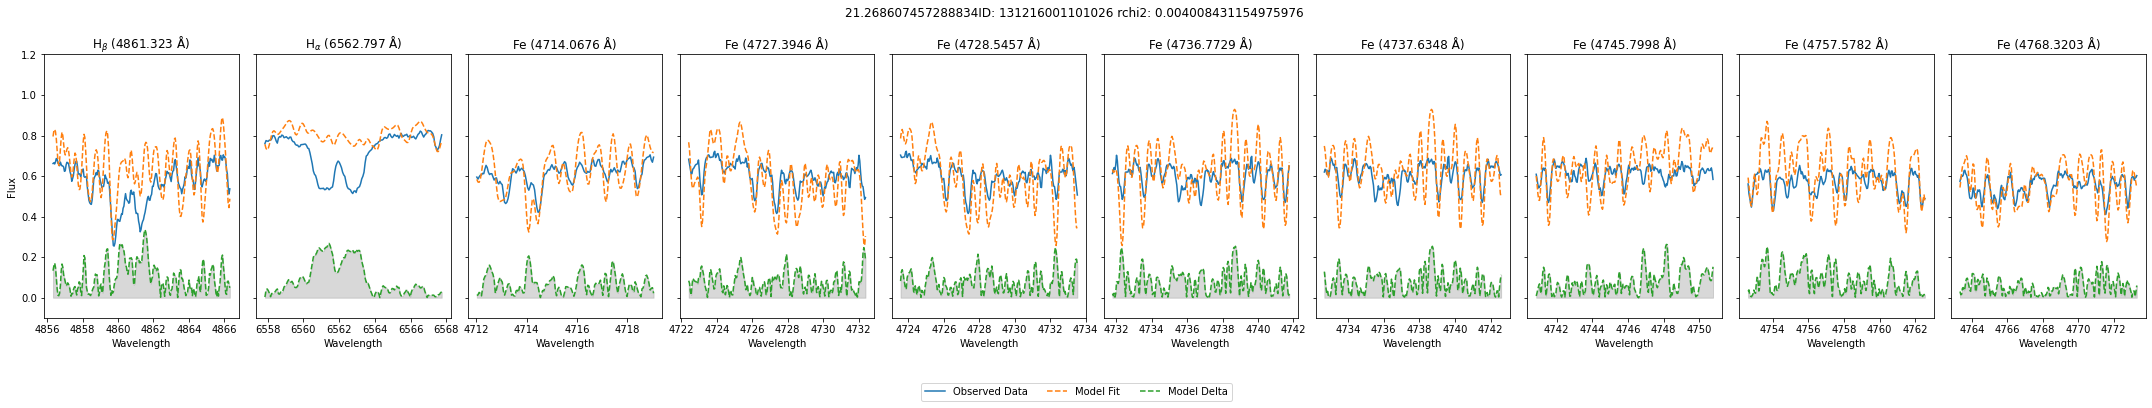

Good curve fit. Updating bounds and initial parameters
Resricted bounds
[(0.4499138254066304, 0.5498946754969927), (0.13664022021510083, 0.16700471359623434), (0.6753015691728791, 0.82536858454463), (0.5762251231979243, 0.7042751505752407), (0.5764650053186852, 0.7045683398339485), (0.6447885024681417, 0.788074836349951), (0.33749679104912084, 0.41249607794892545), (0.12000064856176516, 0.14666745935326853), (0.13663834925459037, 0.16700242686672154), (0.6753014595536959, 0.8253684505656282), (0.5762269847609892, 0.7042774258189869), (0.3235349881438527, 0.39543165217581994), (0.6447891261539062, 0.7880755986325519), (0.33749659104307683, 0.41249583349709384), (0.12000070803585584, 0.14666753204382382), (0.10508144466798323, 0.12843287681642396), (0.10505826224314473, 0.12840454274162133), (0.07919172766643726, 0.09678988937008998), (0.07915001321702195, 0.09673890504302682), (0.45000000014019215, 0.550000000171346), (0.45000000014019964, 0.5500000001713551)]
Optimizing with L-BFGS-B
{

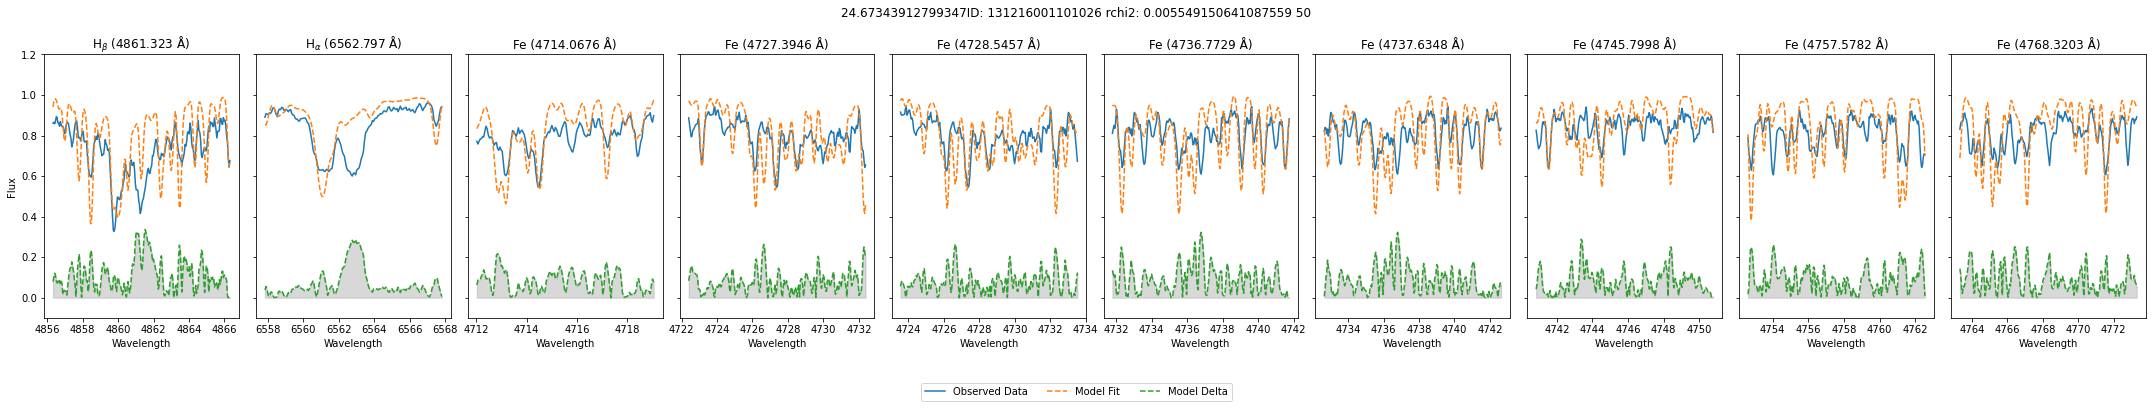

50 {'f_contr': 0.10921226150567016, 'mass_1': 0.842221037837377, 'age_1': 11.11726830035157, 'metallicity_1': -0.3395560943048468, 'rv_1': 116.60420076205119, 'fe_h_1': -0.4300462753868586, 'vmic_1': 1.4880725852252368, 'vsini_1': 4.0476472902309295, 'mass_2': 0.8924026189675809, 'age_2': 11.126788446172025, 'metallicity_2': -0.338272492262774, 'rv_2': 37.93653914070897, 'fe_h_2': -0.42544982375057483, 'vmic_2': 1.4874846518603233, 'vsini_2': 4.053295577949486, 'teff_1': 5.214749535395571, 'teff_2': 4.441083068318525, 'logg_1': 3.1761963856188786, 'logg_2': 2.0113521093479974, 'logl_1': 1.007901875034158, 'logl_2': 1.9194047051430845}


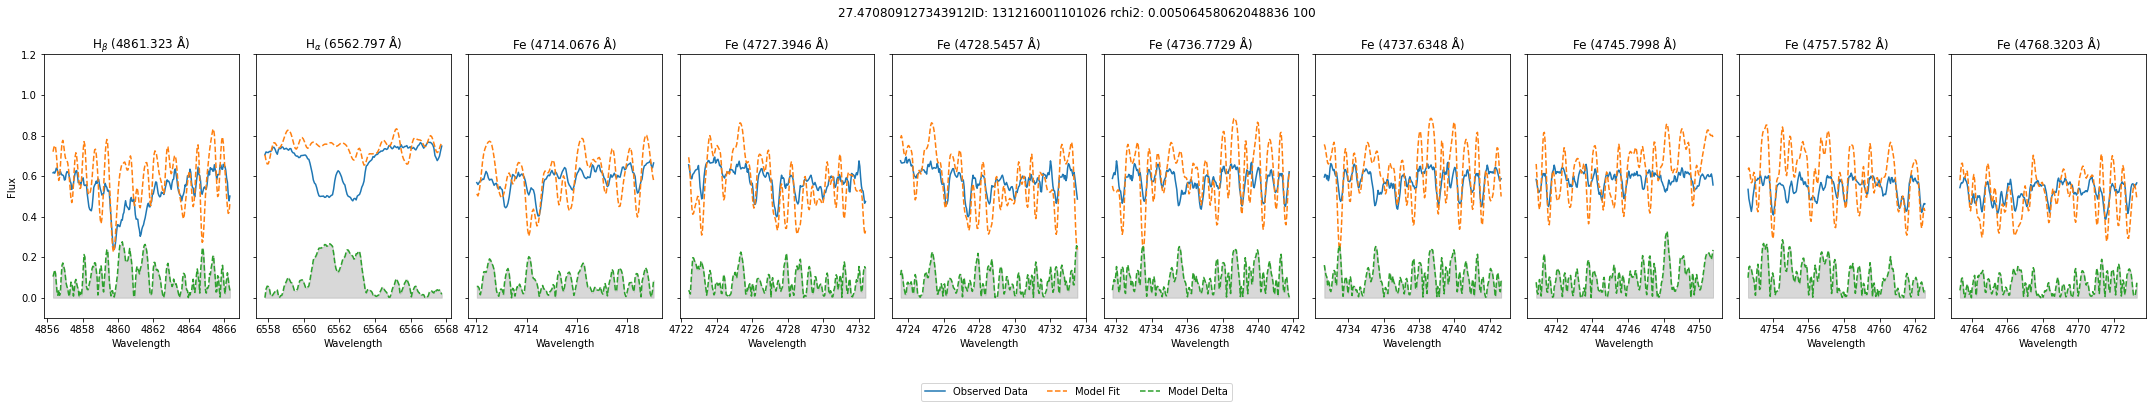

100 {'f_contr': 0.7803698543690339, 'mass_1': 0.8652463634186655, 'age_1': 11.121402184525891, 'metallicity_1': -0.34146416832465976, 'rv_1': 116.39064961107704, 'fe_h_1': -0.42394540053756913, 'vmic_1': 1.494027759547087, 'vsini_1': 4.023840059561999, 'mass_2': 0.8903375958764322, 'age_2': 11.126309424611783, 'metallicity_2': -0.3408047928611002, 'rv_2': 37.968255487647724, 'fe_h_2': -0.42164490170857905, 'vmic_2': 1.4937332793172655, 'vsini_2': 4.026665859171979, 'teff_1': 3.4923946459344855, 'teff_2': 3.9075600797429195, 'logg_1': 0.31783800765296416, 'logg_2': 1.0762088245302268, 'logl_1': 3.1818032341356943, 'logl_2': 2.6311946993959903}


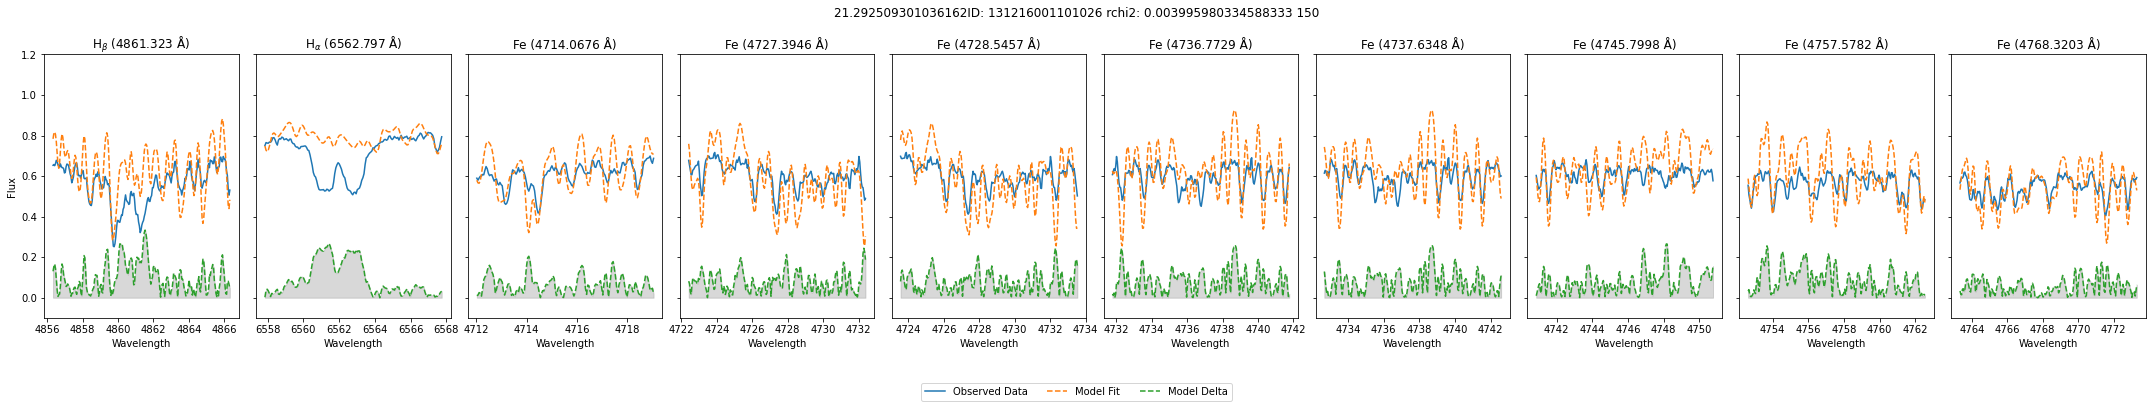

150 {'f_contr': 0.5000485315042845, 'mass_1': 0.8882661094100122, 'age_1': 11.125535066960692, 'metallicity_1': -0.343342917068137, 'rv_1': 116.17715020868076, 'fe_h_1': -0.4178460040769263, 'vmic_1': 1.4999814907870304, 'vsini_1': 4.00003859795741, 'mass_2': 0.888273073190024, 'age_2': 11.125536671933736, 'metallicity_2': -0.3433364798221126, 'rv_2': 37.99996414895311, 'fe_h_2': -0.4178409016906688, 'vmic_2': 1.4999803925815511, 'vsini_2': 4.00004259341554, 'teff_1': 3.583610282463381, 'teff_2': 3.583668246716537, 'logg_1': 0.43963084177841194, 'logg_2': 0.4397450320032201, 'logl_1': 3.115614436629649, 'logl_2': 3.1155301287713475}
Step size between iterations: 9.99999999995449e-06
Step size between iterations: 9.99999999995449e-06


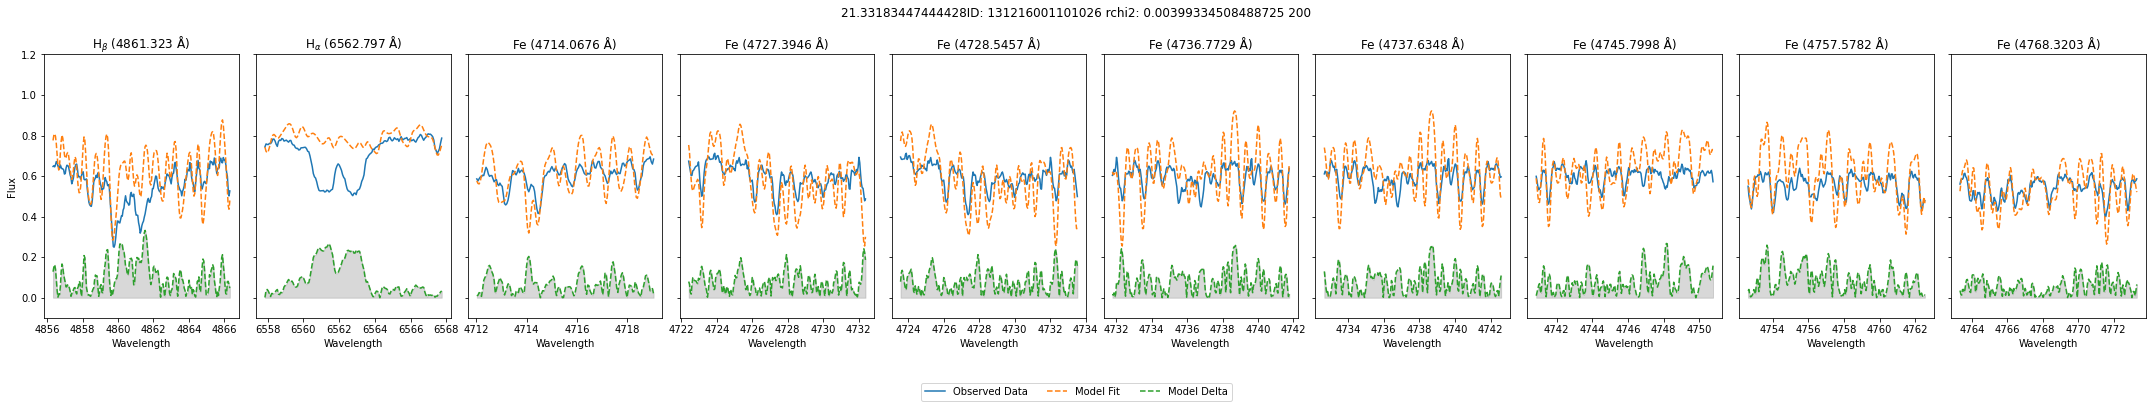

200 {'f_contr': 0.501080543458465, 'mass_1': 0.8873555500861411, 'age_1': 11.125380660146812, 'metallicity_1': -0.34319480160942484, 'rv_1': 116.20831404529835, 'fe_h_1': -0.4187677349655612, 'vmic_1': 1.4990976479773555, 'vsini_1': 4.0034221594889905, 'mass_2': 0.8875359936660724, 'age_2': 11.125441446232706, 'metallicity_2': -0.34293577513846474, 'rv_2': 37.99596299126584, 'fe_h_2': -0.4184230144333916, 'vmic_2': 1.4990632380689783, 'vsini_2': 4.003953395904135, 'teff_1': 3.5737195497185366, 'teff_2': 3.575004901106685, 'logg_1': 0.4217755392399644, 'logg_2': 0.42438117377100976, 'logl_1': 3.1281196568967684, 'logl_2': 3.1262425577286894}
Step size between iterations: 9.99999999995449e-06


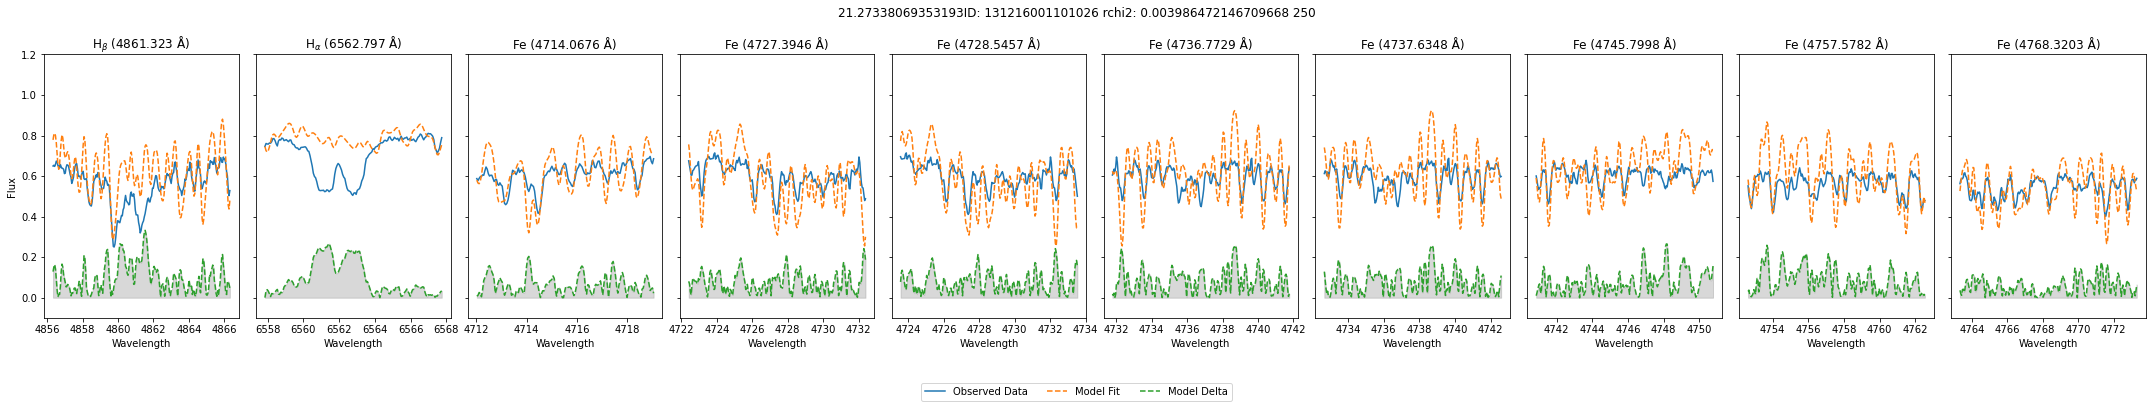

250 {'f_contr': 0.49575045915816585, 'mass_1': 0.8879559399704446, 'age_1': 11.125516393789058, 'metallicity_1': -0.34298113025766885, 'rv_1': 116.29253209109893, 'fe_h_1': -0.4213689142565862, 'vmic_1': 1.4966404001005007, 'vsini_1': 4.01250524808459, 'mass_2': 0.8875584249145229, 'age_2': 11.125573295542768, 'metallicity_2': -0.3419888155582438, 'rv_2': 37.98567317701678, 'fe_h_2': -0.4201257652652082, 'vmic_2': 1.496521734182481, 'vsini_2': 4.014432900314458, 'teff_1': 3.579511437445886, 'teff_2': 3.573039097968742, 'logg_1': 0.4325419782436419, 'logg_2': 0.42175949958535464, 'logl_1': 3.1205232816325372, 'logl_2': 3.1279056679429416}
Step size between iterations: 9.99999999995449e-06


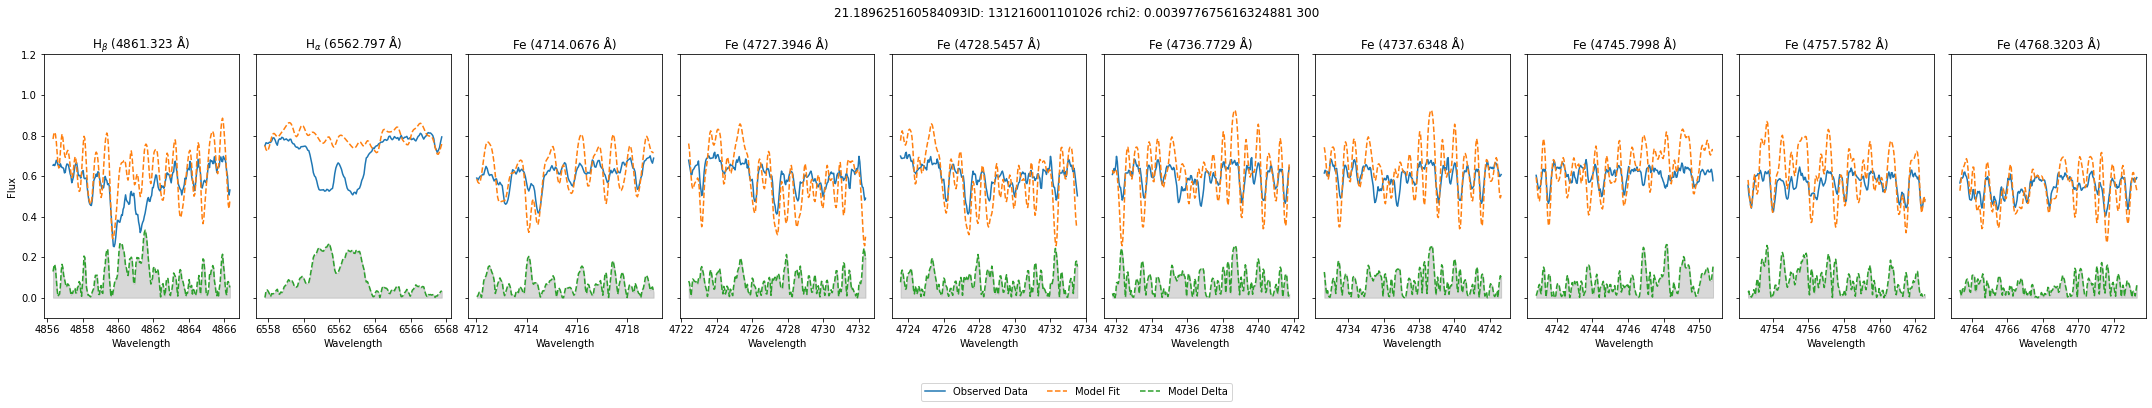

300 {'f_contr': 0.48833777011820073, 'mass_1': 0.8885755576768576, 'age_1': 11.125674608291765, 'metallicity_1': -0.3425760340171582, 'rv_1': 116.44147019340471, 'fe_h_1': -0.42614636677926354, 'vmic_1': 1.4922540514443785, 'vsini_1': 4.028768254400489, 'mass_2': 0.887753293010037, 'age_2': 11.125840450761068, 'metallicity_2': -0.34030367834968134, 'rv_2': 37.96997822366906, 'fe_h_2': -0.4231638902081234, 'vmic_2': 1.4919826057868326, 'vsini_2': 4.0331704437154885, 'teff_1': 3.587705700255316, 'teff_2': 3.5711649610833707, 'logg_1': 0.4490970770135112, 'logg_2': 0.4200525850028309, 'logl_1': 3.1085257435787863, 'logl_2': 3.1287887870201363}
Step size between iterations: 9.99999999995449e-06


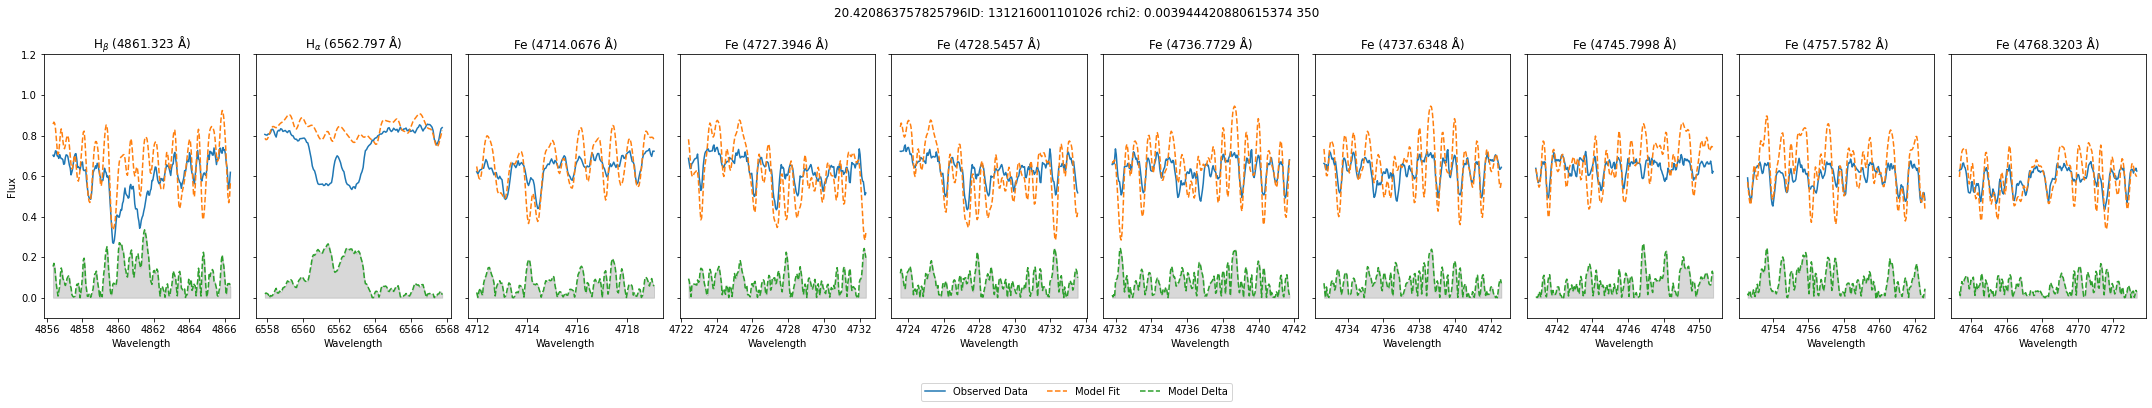

350 {'f_contr': 0.4461330158269522, 'mass_1': 0.8871057945411587, 'age_1': 11.126321334295202, 'metallicity_1': -0.3366535344970647, 'rv_1': 118.44155252672479, 'fe_h_1': -0.48932556013900763, 'vmic_1': 1.4334517222386614, 'vsini_1': 4.24750181078955, 'mass_2': 0.8877106180029056, 'age_2': 11.128901327819294, 'metallicity_2': -0.3174523920423653, 'rv_2': 37.71753479861265, 'fe_h_2': -0.46373105408421367, 'vmic_2': 1.431116380959543, 'vsini_2': 4.285004214817906, 'teff_1': 3.663422824660927, 'teff_2': 3.5845490416920365, 'logg_1': 0.6154553071596831, 'logg_2': 0.4841237434447704, 'logl_1': 2.9773604462297687, 'logl_2': 3.0713015598444873}
Step size between iterations: 9.99999999995449e-06


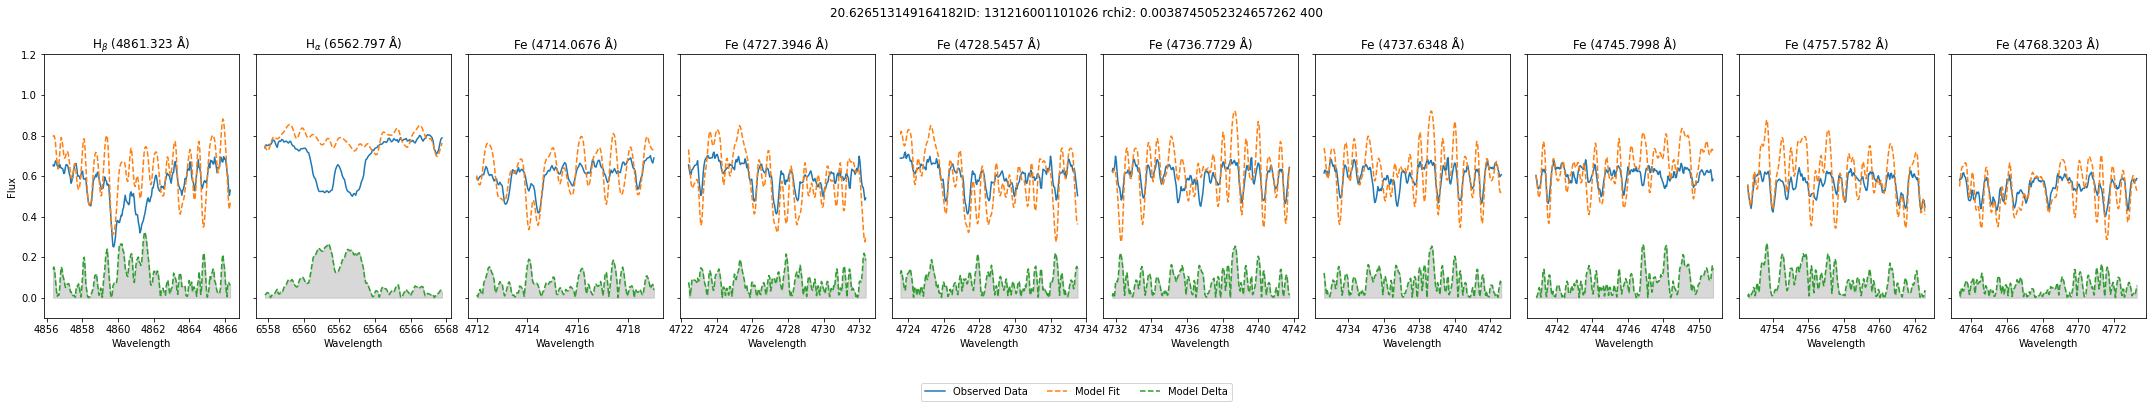

400 {'f_contr': 0.4855372694490154, 'mass_1': 0.8876497854740993, 'age_1': 11.12611582756434, 'metallicity_1': -0.33853606233229994, 'rv_1': 117.80533408185016, 'fe_h_1': -0.4692412999146147, 'vmic_1': 1.45329498077804, 'vsini_1': 4.170758204223936, 'mass_2': 0.8876660314112603, 'age_2': 11.127917629433519, 'metallicity_2': -0.3247134964391214, 'rv_2': 37.796911088913745, 'fe_h_2': -0.4508346885395791, 'vmic_2': 1.4517537788466, 'vsini_2': 4.195523307180715, 'teff_1': 3.5659950560560234, 'teff_2': 3.536333462618506, 'logg_1': 0.41240962649335755, 'logg_2': 0.37287347840238794, 'logl_1': 3.1338221985067545, 'logl_2': 3.1589535453417934}


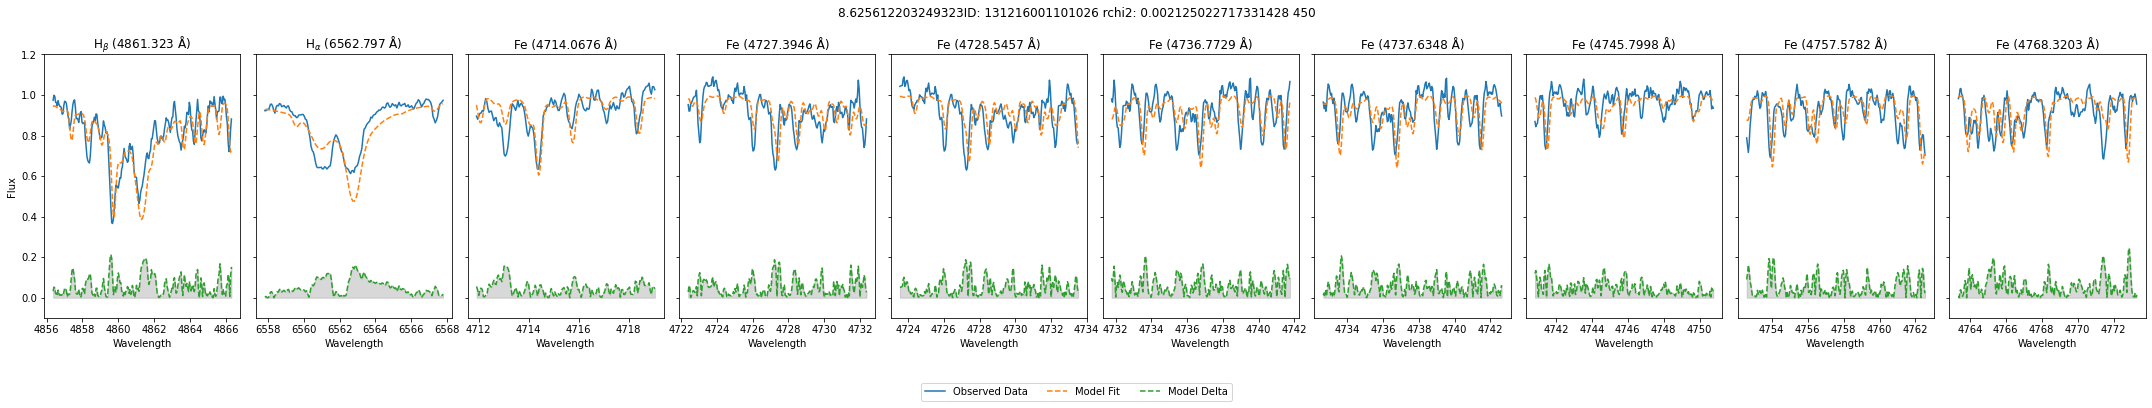

450 {'f_contr': 0.7396776466387004, 'mass_1': 0.8850721329105092, 'age_1': 11.12773417342896, 'metallicity_1': -0.32374257703535503, 'rv_1': 122.77892477712206, 'fe_h_1': -0.6269538415091911, 'vmic_1': 1.3609219083752606, 'vsini_1': 4.3760568808647555, 'mass_2': 0.8848088363380107, 'age_2': 11.135053943189032, 'metallicity_2': -0.2675203565445252, 'rv_2': 37.174181715493816, 'fe_h_2': -0.5520860765162112, 'vmic_2': 1.3607580625976672, 'vsini_2': 4.3783801238473155, 'teff_1': 5.154242290256392, 'teff_2': 5.493577670801137, 'logg_1': 3.1602174522486193, 'logg_2': 3.724310381812916, 'logl_1': 1.0254937200197383, 'logl_2': 0.5719626873879915}
Step size between iterations: 9.99999999995449e-06


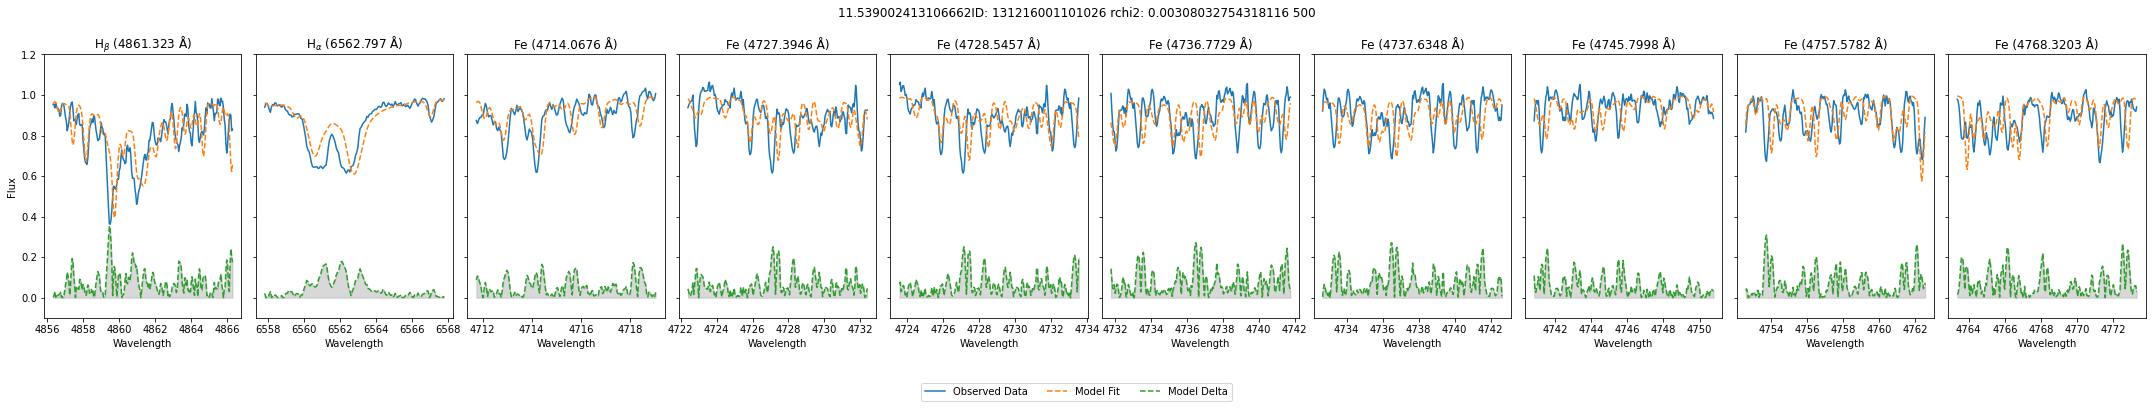

500 {'f_contr': 0.5691130256838158, 'mass_1': 0.861702262116689, 'age_1': 11.130949624082483, 'metallicity_1': -0.26775942877572323, 'rv_1': 133.99469769523864, 'fe_h_1': -0.7760574876592914, 'vmic_1': 1.3499871641964833, 'vsini_1': 4.4000237805980555, 'mass_2': 0.8084444403806361, 'age_2': 11.153225362469115, 'metallicity_2': -0.15849811443484274, 'rv_2': 34.867774702881235, 'fe_h_2': -0.7760543692304691, 'vmic_2': 1.3500263641723074, 'vsini_2': 4.400025961314714, 'teff_1': 4.971662502016751, 'teff_2': 4.511570571236912, 'logg_1': 2.7624540800977218, 'logg_2': 2.687484749603868, 'logl_1': 1.3485867757022274, 'logl_2': 1.2277516155759454}


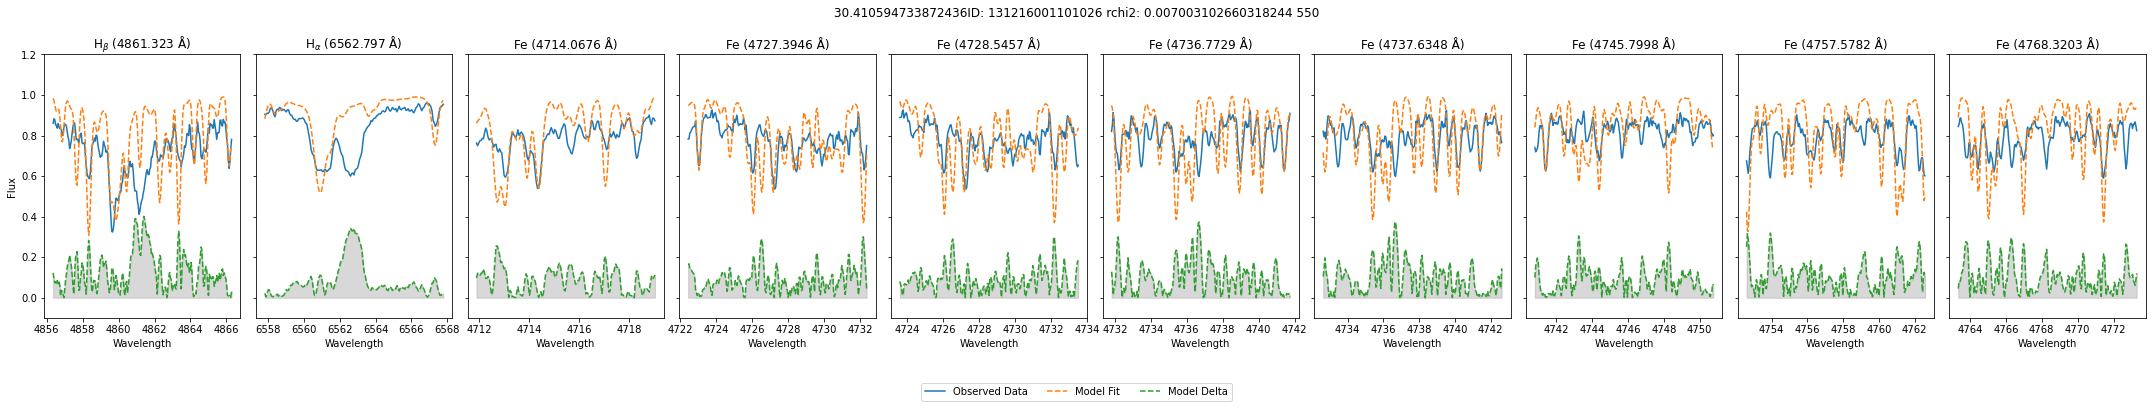

550 {'f_contr': 0.03443825713911231, 'mass_1': 0.8844575141391466, 'age_1': 11.127915070406631, 'metallicity_1': -0.32160742815248256, 'rv_1': 123.35902373429278, 'fe_h_1': -0.6416082022424812, 'vmic_1': 1.3537222974526528, 'vsini_1': 4.39173459680591, 'mass_2': 0.8832093174685103, 'age_2': 11.13592393579662, 'metallicity_2': -0.2612109159502971, 'rv_2': 37.08521198753742, 'fe_h_2': -0.5638166545465371, 'vmic_2': 1.3536658036137967, 'vsini_2': 4.39263209035987, 'teff_1': 5.542946501467219, 'teff_2': 4.212169364216553, 'logg_1': 3.7078864674546343, 'logg_2': 1.7830146827735558, 'logl_1': 0.6038217198332864, 'logl_2': 2.0515606053622206}
Step size between iterations: 9.99999999995449e-06


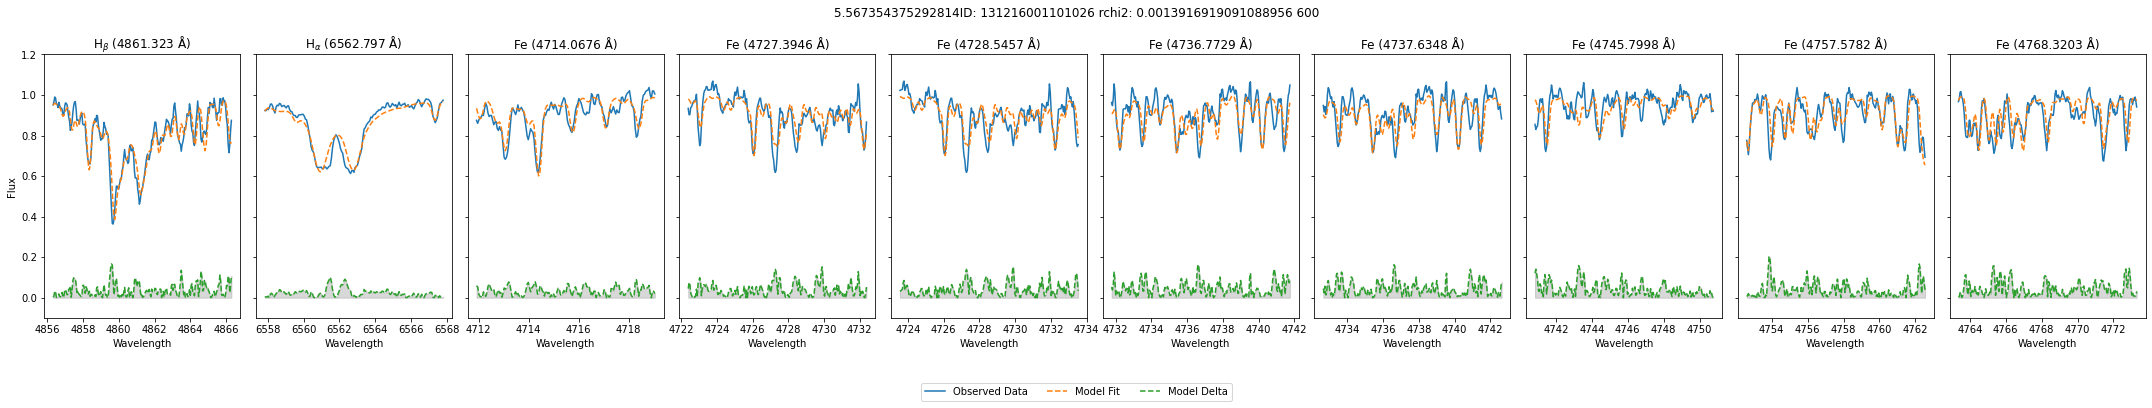

600 {'f_contr': 0.494126133121243, 'mass_1': 0.8851610371349952, 'age_1': 11.127674766991854, 'metallicity_1': -0.32405204944475474, 'rv_1': 122.60789054832105, 'fe_h_1': -0.6219280659551356, 'vmic_1': 1.3625920632018993, 'vsini_1': 4.3680615374833085, 'mass_2': 0.8840860573812053, 'age_2': 11.134768304723123, 'metallicity_2': -0.2695841227244493, 'rv_2': 37.188908712841695, 'fe_h_2': -0.5486213067081827, 'vmic_2': 1.3625362304761548, 'vsini_2': 4.3689483065243, 'teff_1': 5.0912220632139125, 'teff_2': 4.997573558509288, 'logg_1': 3.068652304752951, 'logg_2': 3.02586018426343, 'logl_1': 1.0957085832488478, 'logl_2': 1.1059130045924794}
Step size between iterations: 9.99999999995449e-06


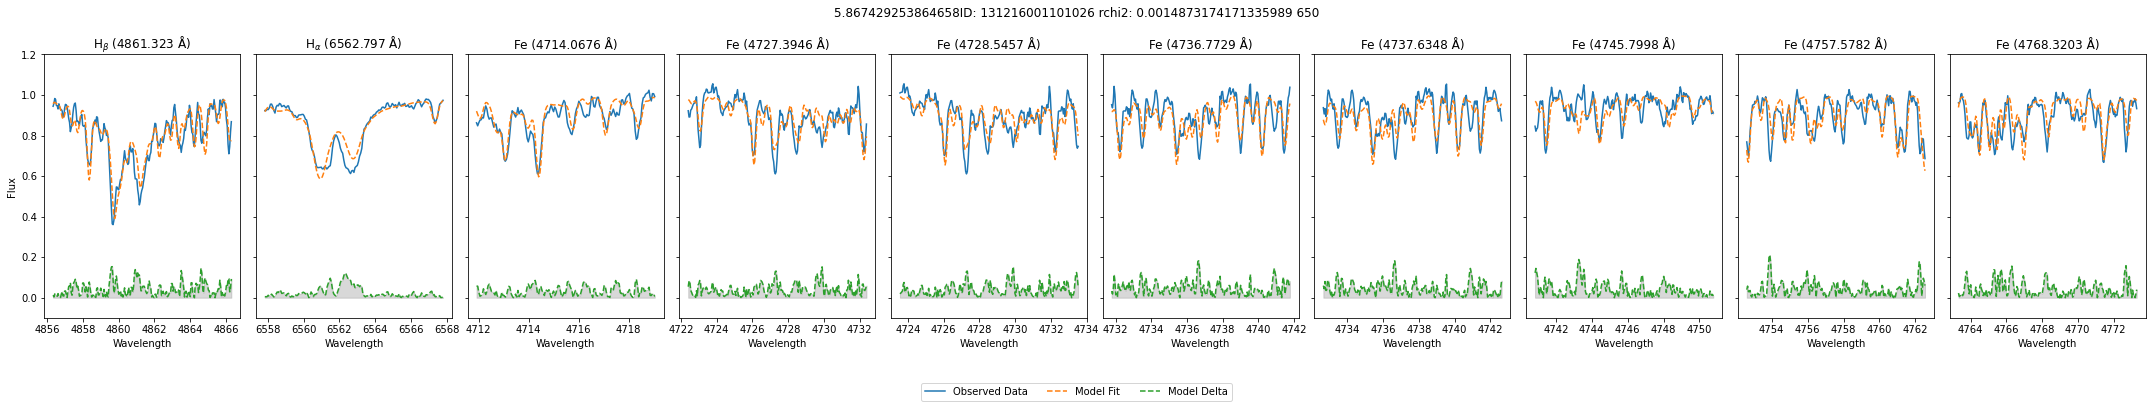

650 {'f_contr': 0.411578027699932, 'mass_1': 0.8851603788463861, 'age_1': 11.127585610966419, 'metallicity_1': -0.32467632439627225, 'rv_1': 122.38918465031045, 'fe_h_1': -0.6149473767315565, 'vmic_1': 1.3665299732044813, 'vsini_1': 4.357537660772935, 'mass_2': 0.8840002206324408, 'age_2': 11.134595003835145, 'metallicity_2': -0.2721246809579059, 'rv_2': 37.21430367196004, 'fe_h_2': -0.5441793390756784, 'vmic_2': 1.366474892112551, 'vsini_2': 4.358412303562836, 'teff_1': 5.085444199643534, 'teff_2': 4.8673323999993015, 'logg_1': 3.0592792204715025, 'logg_2': 2.8274861279942924, 'logl_1': 1.1031151919453832, 'logl_2': 1.258351891640051}


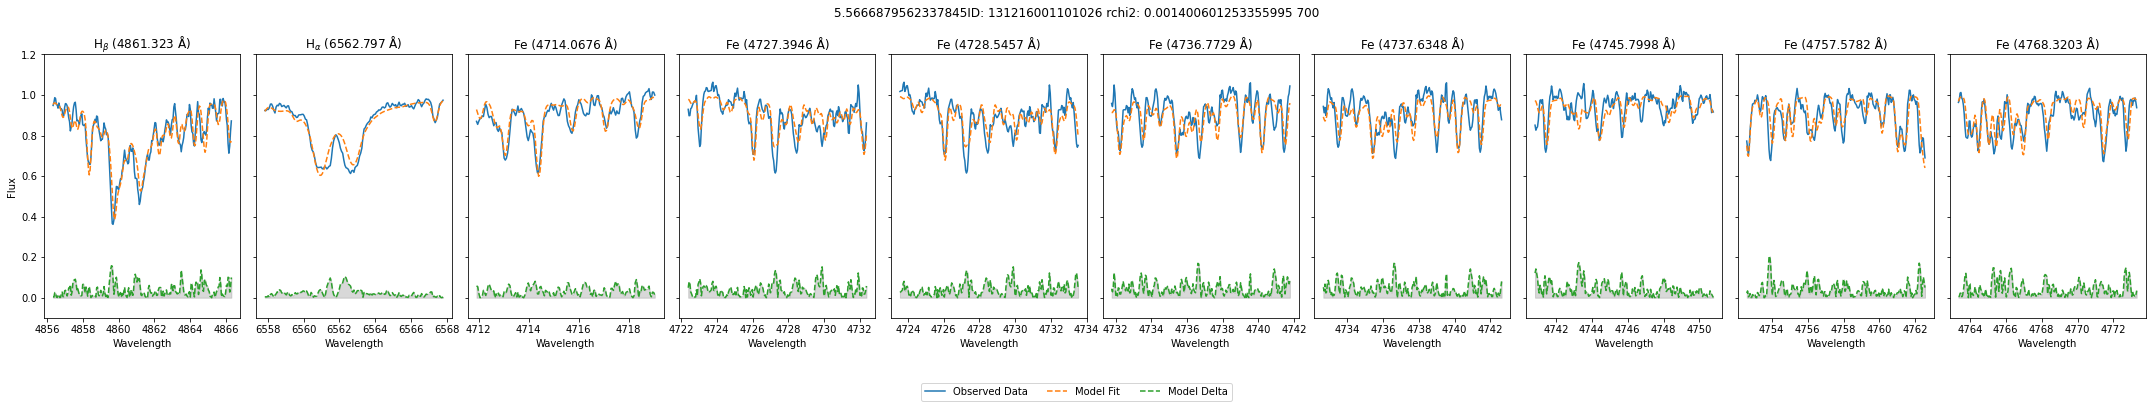

700 {'f_contr': 0.4545954982119357, 'mass_1': 0.8851605766159539, 'age_1': 11.127612396100439, 'metallicity_1': -0.3244974469280999, 'rv_1': 122.45489043700266, 'fe_h_1': -0.6170445843572367, 'vmic_1': 1.3653469073749982, 'vsini_1': 4.360699347790051, 'mass_2': 0.8840260085565708, 'age_2': 11.134544272786004, 'metallicity_2': -0.2713614213527238, 'rv_2': 37.206674267439794, 'fe_h_2': -0.5455138388784269, 'vmic_2': 1.3652916004698112, 'vsini_2': 4.361577633668111, 'teff_1': 5.08708969428938, 'teff_2': 4.9344969916935675, 'logg_1': 3.061951240015847, 'logg_2': 2.92957667588801, 'logl_1': 1.1010034300575136, 'logl_2': 1.1800970176999765}
Step size between iterations: 9.99999999995449e-06


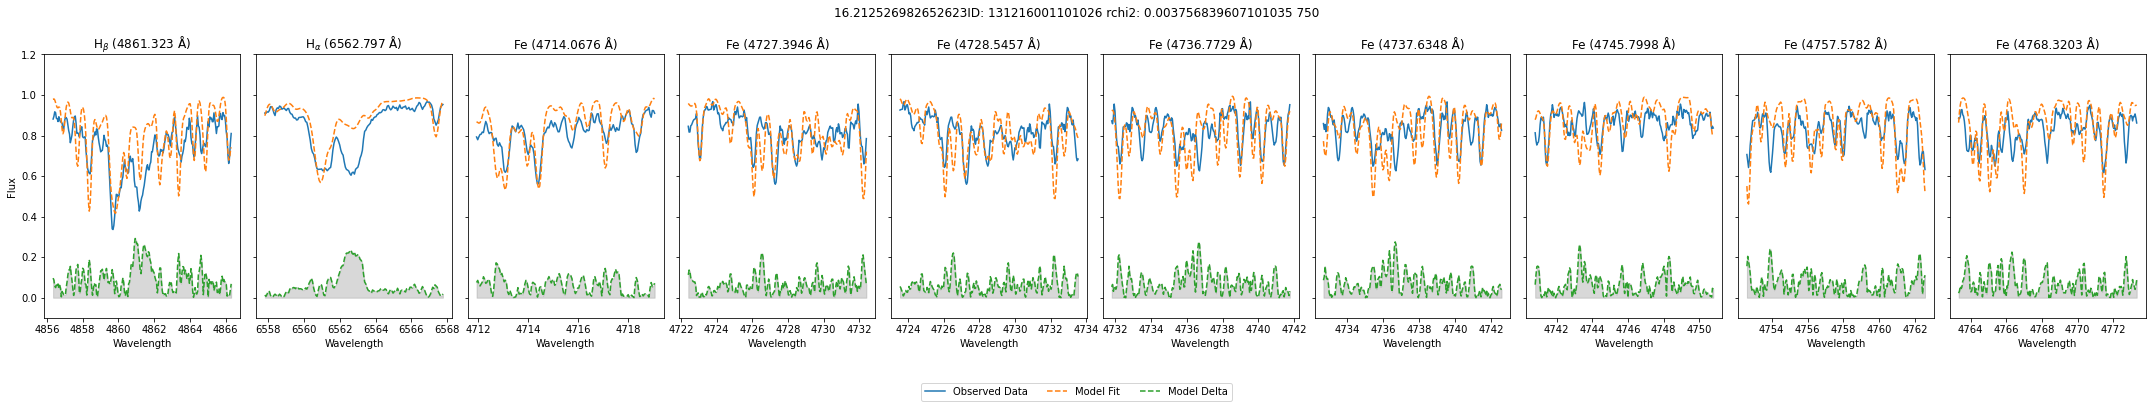

750 {'f_contr': 0.2139383343125029, 'mass_1': 0.8854558758193561, 'age_1': 11.127364071249323, 'metallicity_1': -0.3264851152210366, 'rv_1': 121.7773699827392, 'fe_h_1': -0.5975734954019076, 'vmic_1': 1.3701718719329838, 'vsini_1': 4.3611811027208605, 'mass_2': 0.8836034185080074, 'age_2': 11.133441400872433, 'metallicity_2': -0.2790829513382078, 'rv_2': 37.29096755744908, 'fe_h_2': -0.5317544500014924, 'vmic_2': 1.3696714140204702, 'vsini_2': 4.369258889088724, 'teff_1': 4.874023710091237, 'teff_2': 4.3415879550095235, 'logg_1': 2.742084176879006, 'logg_2': 1.975238207877097, 'logl_1': 1.3466223994980813, 'logl_2': 1.9117904066679994}


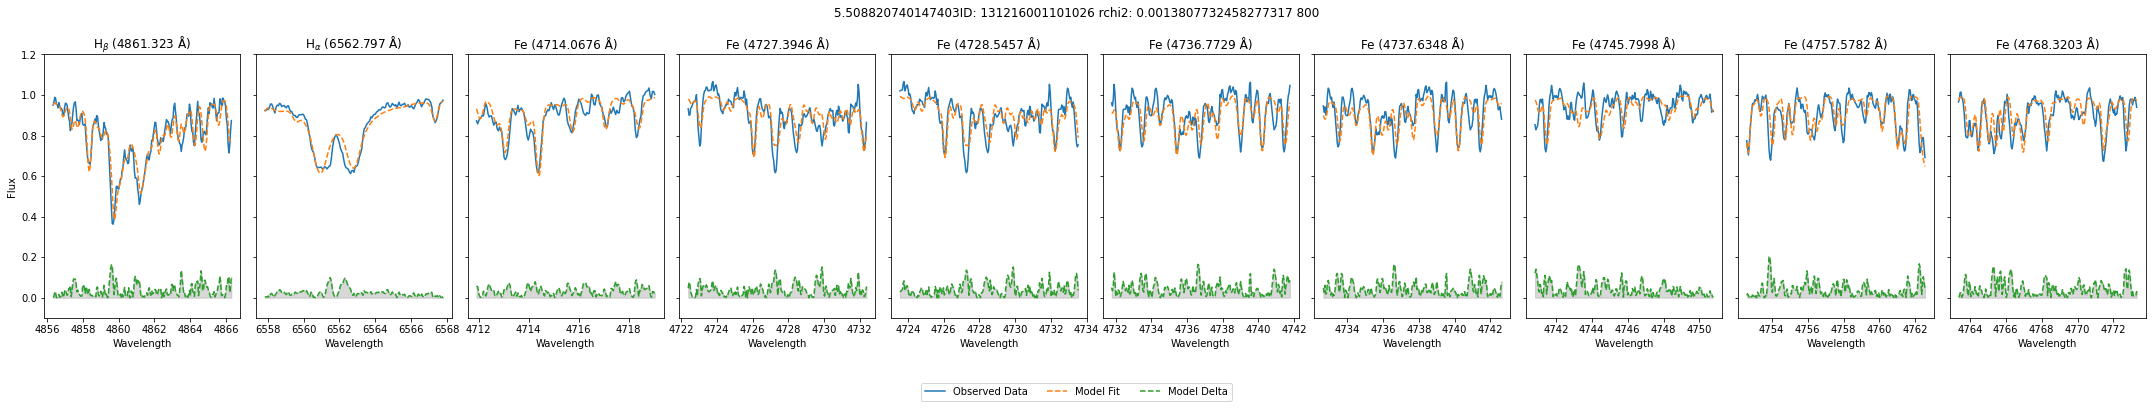

800 {'f_contr': 0.478384627063347, 'mass_1': 0.8851607823460227, 'age_1': 11.127626712174102, 'metallicity_1': -0.3244019516518808, 'rv_1': 122.4899857425809, 'fe_h_1': -0.6181154869957757, 'vmic_1': 1.364712516274837, 'vsini_1': 4.362399230723081, 'mass_2': 0.8840397298663881, 'age_2': 11.134595624135212, 'metallicity_2': -0.2709536928860805, 'rv_2': 37.20260108126743, 'fe_h_2': -0.5462266331005585, 'vmic_2': 1.364656938117323, 'vsini_2': 4.3632818987568625, 'teff_1': 5.087901247223217, 'teff_2': 4.971437142364625, 'logg_1': 3.063280036185144, 'logg_2': 2.9851211241551296, 'logl_1': 1.0999508332218826, 'logl_2': 1.1375240004593468}


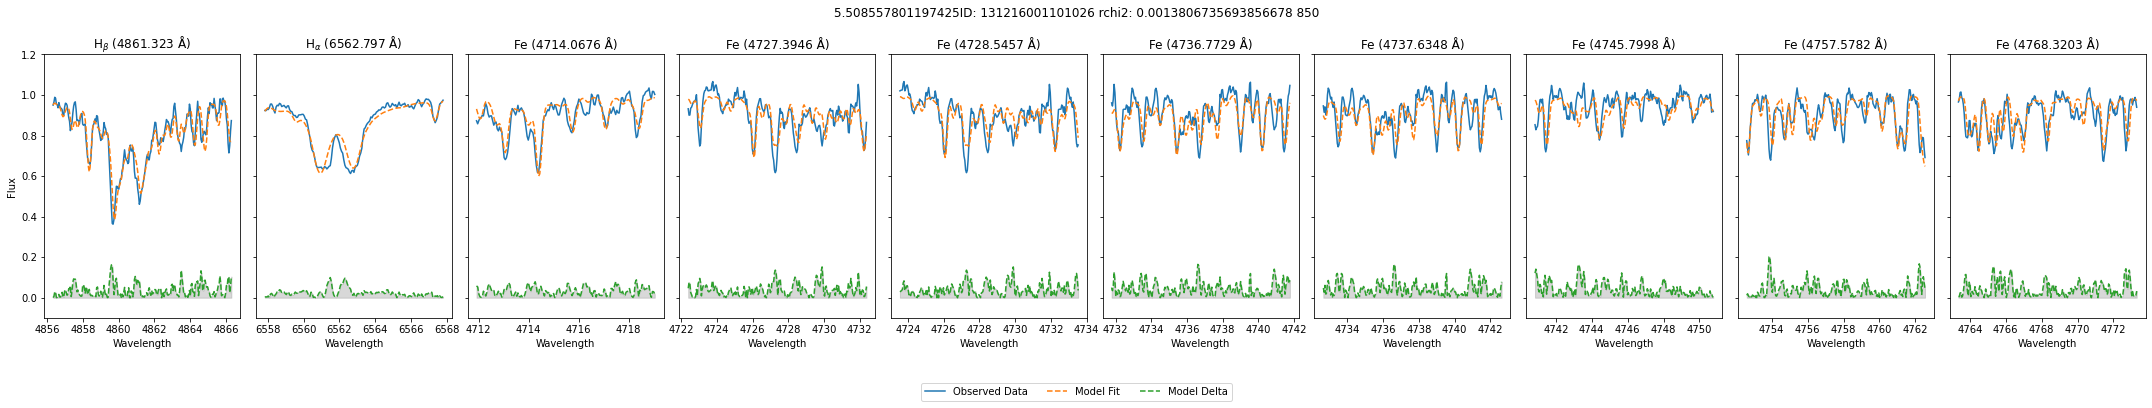

850 {'f_contr': 0.47859766288971095, 'mass_1': 0.8851606832818067, 'age_1': 11.127626800343851, 'metallicity_1': -0.32440125232443195, 'rv_1': 122.49022497092037, 'fe_h_1': -0.6181723998206565, 'vmic_1': 1.3647106835444063, 'vsini_1': 4.36239963965417, 'mass_2': 0.884039876338088, 'age_2': 11.13459601161319, 'metallicity_2': -0.2709509638571843, 'rv_2': 37.20535318610794, 'fe_h_2': -0.5462314914779984, 'vmic_2': 1.3646552547350417, 'vsini_2': 4.363279892254127, 'teff_1': 5.087974600187384, 'teff_2': 4.971834508806675, 'logg_1': 3.0633878630943983, 'logg_2': 2.9857136924476, 'logl_1': 1.0998680244563896, 'logl_2': 1.137070424439381}


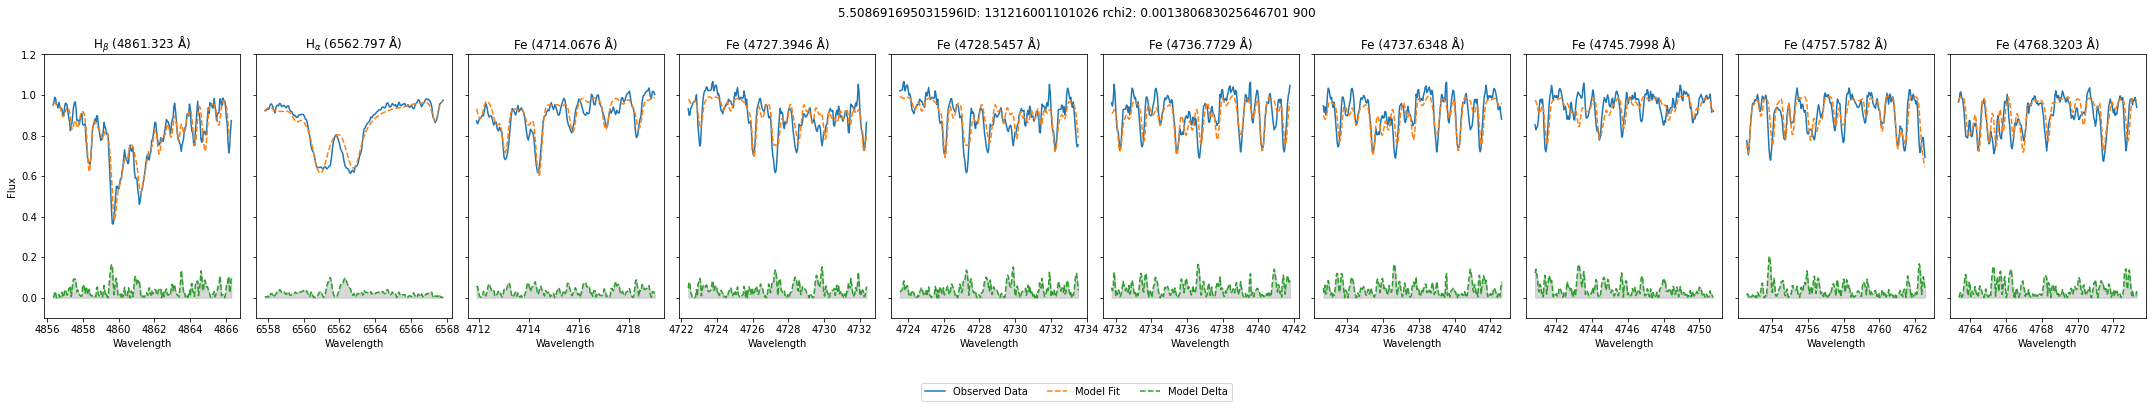

900 {'f_contr': 0.47859832592060725, 'mass_1': 0.885160682973495, 'age_1': 11.127626800618255, 'metallicity_1': -0.3244012501479574, 'rv_1': 122.49022571545623, 'fe_h_1': -0.6181724213350224, 'vmic_1': 1.3647106778405105, 'vsini_1': 4.362399640926862, 'mass_2': 0.8840398767939431, 'age_2': 11.134596012819115, 'metallicity_2': -0.27095095536379277, 'rv_2': 37.20257132391633, 'fe_h_2': -0.5462315065984322, 'vmic_2': 1.364655249495953, 'vsini_2': 4.363279886009409, 'teff_1': 5.087974828481122, 'teff_2': 4.9718357455561835, 'logg_1': 3.0633881986777016, 'logg_2': 2.9857155366626187, 'logl_1': 1.099867766735573, 'logl_2': 1.1370690128017387}


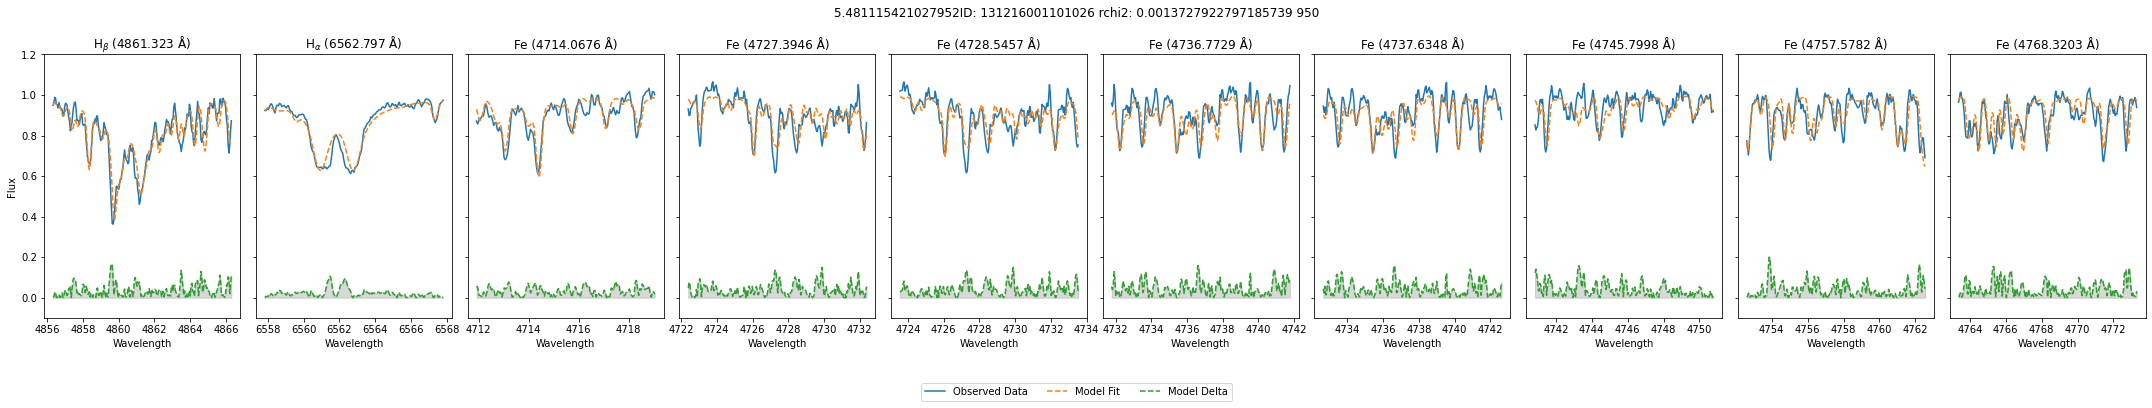

950 {'f_contr': 0.501172348854835, 'mass_1': 0.8852132629725995, 'age_1': 11.127626800619053, 'metallicity_1': -0.3244012501416347, 'rv_1': 122.49022571761907, 'fe_h_1': -0.6181724213975213, 'vmic_1': 1.3647106778239406, 'vsini_1': 4.362399640930558, 'mass_2': 0.8840398767952674, 'age_2': 11.134596012822618, 'metallicity_2': -0.27095095533911984, 'rv_2': 37.20257132364813, 'fe_h_2': -0.5462315066423571, 'vmic_2': 1.3646552494807336, 'vsini_2': 4.363279885991269, 'teff_1': 5.052876605721196, 'teff_2': 4.9718357491490135, 'logg_1': 3.012135844652381, 'logg_2': 2.9857155420201797, 'logl_1': 1.1391055909870398, 'logl_2': 1.1370690087008426}
Step size between iterations: 9.99999999995449e-06


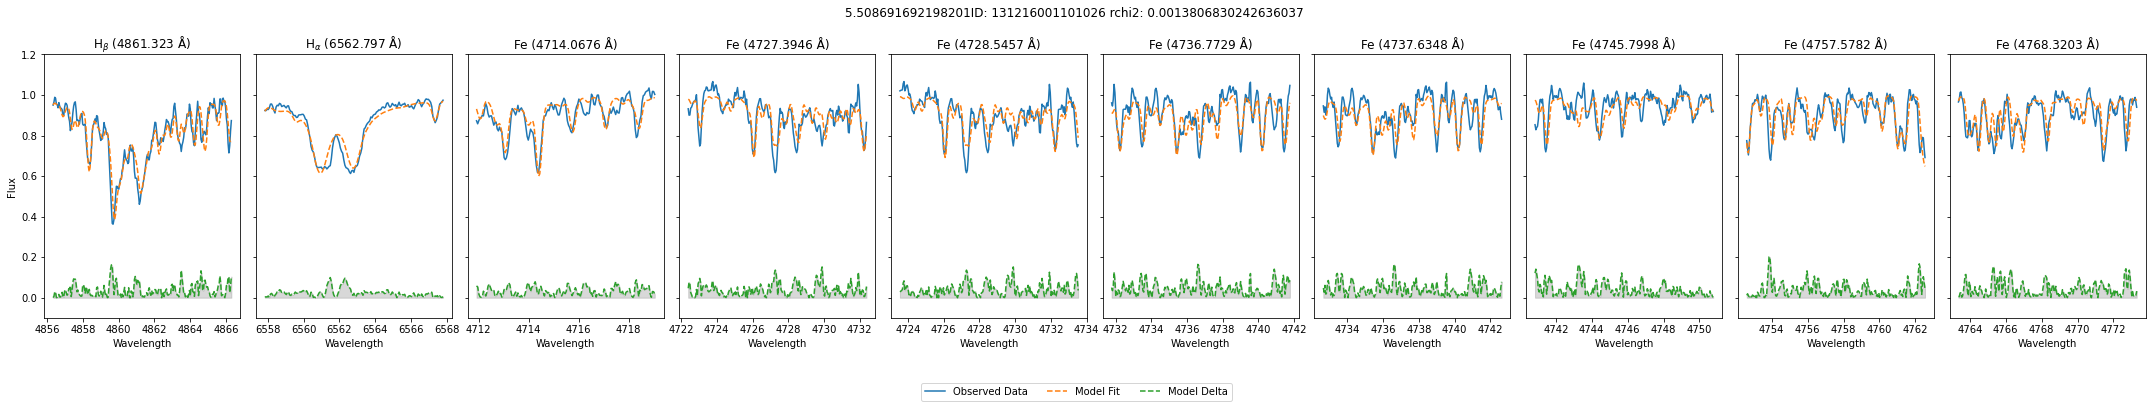

Final parameters:
{'f_contr': 0.4785983278468126, 'mass_1': 0.8851606829725994, 'age_1': 11.127626800619053, 'metallicity_1': -0.3244012501416347, 'rv_1': 122.49022571761907, 'fe_h_1': -0.6181724213975213, 'vmic_1': 1.3647106778239406, 'vsini_1': 4.362399640930558, 'mass_2': 0.8840398767952674, 'age_2': 11.134596012822618, 'metallicity_2': -0.27095095533911984, 'rv_2': 37.20257132364813, 'fe_h_2': -0.5462315066423571, 'vmic_2': 1.3646552494807336, 'vsini_2': 4.363279885991269, 'teff_1': 5.087974829144241, 'teff_2': 4.9718357491490135, 'logg_1': 3.063388199652459, 'logg_2': 2.9857155420201797, 'logl_1': 1.0998677659869802, 'logl_2': 1.1370690087008426}


In [4]:
import multiprocessing
import stellarmodel
importlib.reload(stellarmodel)
importlib.reload(af)
from stellarmodel import StellarModel

def normalize_parameters(params, bounds):
    normalized_params = [(p - lb) / (ub - lb) for p, (lb, ub) in zip(params, bounds)]
    return normalized_params

def denormalize_parameters(normalized_params, bounds):
    denormalized_params = [lb + n * (ub - lb) for n, (lb, ub) in zip(normalized_params, bounds)]
    return denormalized_params


# Global variable to store the previous parameter values
previous_params = None

# Define the callback function
def track_step_size(current_params):
    global previous_params
    if previous_params is not None:
        step_size = np.linalg.norm(current_params - previous_params)
        print(f"Step size between iterations: {step_size}")
    previous_params = np.copy(current_params)

def fit_model(sobject_id):
    # sobject_id = 140116004301399
    sobject_data = GALAH_DR4[GALAH_DR4['sobject_id'] == sobject_id]
    if sobject_data.size == 0:
        print('No data for sobject_id in GALAH DR4: ', sobject_id)
        return

    tmass_id = sobject_data['tmass_id'].values[0]

    spectrum = af.read_spectrum(sobject_id, tmass_id)
    if spectrum == False:
        return

    same_fe_h = False

    try:
        single_results = Table.read('/avatar/buder/GALAH_DR4/analysis_products_single/'+str(sobject_id)[:6]+'/'+str(sobject_id)+'/'+str(sobject_id)+'_single_fit_results.fits')
    except:
        print('Single results not available')
        return

    # model = StellarModel(labels = ['teff', 'logg', 'rv', 'fe_h', 'vmic', 'vsini']) # Model with no interpolation
    model = StellarModel(id=sobject_id, labels = ['mass', 'age', 'metallicity', 'rv', 'fe_h', 'vmic', 'vsini'], interpolator=isochrone_interpolator, interpolate_flux=True) # Flux can be used as a free parameter (False) or can be determined from luminosity ratios (from the isochrone) (True)


    model.bounds['f_contr'] = (0, 1)

    # Same bounds for both components. Overwrite with model.bounds['rv_1'] == x if required
    model.set_bounds('teff', (3, 8))
    model.set_bounds('logg', (0.0, 5.0))
    model.set_bounds('fe_h', (-4.0, 1.0))
    model.set_bounds('vmic', (0, 4))
    model.set_bounds('vsini', (0, 30))

    age_min = (10**isochrone_table['logAge'].min()) / 1e9
    age_max = (10**isochrone_table['logAge'].max()) / 1e9

    model.set_bounds('age', (age_min, age_max))
    model.set_bounds('mass', (isochrone_table['mass'].min(), isochrone_table['mass'].max()))
    model.set_bounds('metallicity', (isochrone_table['m_h'].min(), isochrone_table['m_h'].max()))
    model.set_bounds('logL', (isochrone_table['logL'].min(), isochrone_table['logL'].max()))

    model.params['f_contr'] = 0.5


    model.params['rv_1'] = single_results['rv_gauss'][0]
    model.params['rv_2'] = single_results['rv_peak_2'][0]
    if np.isnan(model.params['rv_2']):
        return

    min_rv = min(model.params['rv_1'], model.params['rv_2']) - 100
    max_rv = max(model.params['rv_1'], model.params['rv_2']) + 100
    model.set_bounds('rv', (min_rv, max_rv))

    model.set_param('teff', single_results['teff'][0]/1000.)
    model.set_param('logg', single_results['logg'][0])

    model.set_param('age', sobject_data['age'].values[0].clip(age_min, age_max))
    model.set_param('mass', sobject_data['mass'].values[0])
    model.set_param('metallicity', sobject_data['fe_h'].values[0]) # Approximate m_h as fe_h

    model.set_param('fe_h', single_results['fe_h'][0])
    model.set_param('vmic', 1.5)
    model.set_param('vsini', 4.0)

    af.load_neural_network(spectrum)
    af.set_iterations(0)
    af.load_dr3_lines()

    print("fitting with rvs: ", model.params['rv_1'], model.params['rv_2'], sobject_id)



    # Generate an initial model with the starting parameters
    print("Initial parameters:")
    print(model.params)
    wave_init, data_init, sigma2_init, model_init, unmasked_init = af.return_wave_data_sigma_model(model, spectrum, same_fe_h)
    unmasked = unmasked_init

    # Produce a plot with the initial parameters
    model.generate_model(spectrum)
    model.plot()




    def objective_function_norm(normalized_params):

        global previous_params

        # Denormalize the parameters
        model_parameters = denormalize_parameters(normalized_params, model.get_bounds(type='tuple'))

        # Calculate the model flux using the current parameters
        model_flux = af.get_flux_only(wave_init, model, spectrum, same_fe_h, unmasked, *model_parameters, plot=True)
        
        # Need to generate a model with the current parameters to determine residual
        model.generate_model(spectrum)
        # residuals = model.get_residual()
        residuals = model.get_rchi2()


        # print('Step ', np.array(normalized_params - previous_params))
        previous_params = np.copy(normalized_params)
        
        return residuals


    # Fit the model to the data. This takes the model parameters and produces a synthetic spectra using the neural network. It then compares this to the observed data and adjusts the model parameters (and thereby the synthetic spectra from the NN) to minimize the difference between the two.
    kwargs={'maxfev':20000,'xtol':1e-5, 'gtol':1e-5, 'ftol':1e-5}
    model_parameters_iter1, covariances_iter1 = curve_fit(
        lambda wave_init, 
            *model_parameters: af.get_flux_only(wave_init, model, spectrum, same_fe_h, unmasked, *model_parameters, plot=True),
        wave_init[unmasked_init],
        data_init[unmasked_init],
        p0=model.get_params(values_only=True),
        sigma=np.sqrt(sigma2_init[unmasked_init]),
        absolute_sigma=True,
        bounds=model.get_bounds(),
        **kwargs
    )



    # Get the original parameter values and bounds
    original_params = model.get_params(values_only=True)# model_parameters_iter1 # model.get_params(values_only=True)
    bounds = model.get_bounds(type='tuple')


    # Normalize the initial parameter values
    normalized_x0 = normalize_parameters(original_params, bounds)
    
    # If the curve fit hasn't failed, assume the parameters returned from it are good. 
    # Use these new values to update the bounds for the minimization and as the initial guess for the next optimization.
    if model.get_residual() < 10:
        print("Good curve fit. Updating bounds and initial parameters")
        # Update bounds to so that they are within 25% of the values returned by curve_fit
        margin = 0.1
        bounds = [(max(lb, p - margin * abs(p)), min(ub, p + margin * abs(p)) ) for p, (lb, ub) in zip(normalized_x0, [(0, 1)] * len(bounds))]
        print("Resricted bounds")
        print(bounds)
        # Ensure these new bounds are also within the (0, 1) bounds
        bounds = [(max(0, lb), min(1, ub)) for lb, ub in bounds]
            
    else:
        bounds = [(0, 1)] * len(bounds)


    

    # print("New bounds:")
    # print(model.get_bounds(type='tuple'))
    # print(bounds)

    # print("Normalized initial parameters:")
    # print(normalized_x0)

    # global previous_params
    # previous_params = normalized_x0

    print("Optimizing with L-BFGS-B")
    print(model.get_params())
    print(normalized_x0)
    print(bounds)

    result = scipy.optimize.minimize(
        objective_function_norm,
        x0=normalized_x0, #model.get_params(values_only=True),
        method='L-BFGS-B',
        bounds= bounds, #[(0, 1)] * len(bounds), #model.get_bounds(type='tuple'),
        # Ftol is the relative error desired in the sum of squares.
        # Gtol is the gradient norm desired in the sum of squares.
        options={'maxfun': 10000, 'gtol': 1e-10, 'ftol': 1e-10, 'eps': 1e-5}, #, ,
        callback=track_step_size  # Pass the callback function 
    )

    model.plot()
    print("Final parameters:")
    print(model.params)

    


if locals().get('pool'):
    pool.close()

# Create a pool of worker processes
pool = multiprocessing.Pool(processes=1)

# Iterate over the sobject_ids and apply the fit_model function in parallel
test_ids = [170712002601388 ]
test_ids = [131216002101139] # Sven's Star
test_ids = [131216001101026]
# results = pool.map(fit_model, random_stars['sobject_id'].values[2:3])
results = pool.map(fit_model, test_ids)

# Close the pool to prevent any more tasks from being submitted
pool.close()

# Wait for all the worker processes to finish
pool.join()


In [7]:
stellar_model.plot()

NameError: name 'stellar_model' is not defined

IndexError: list index out of range

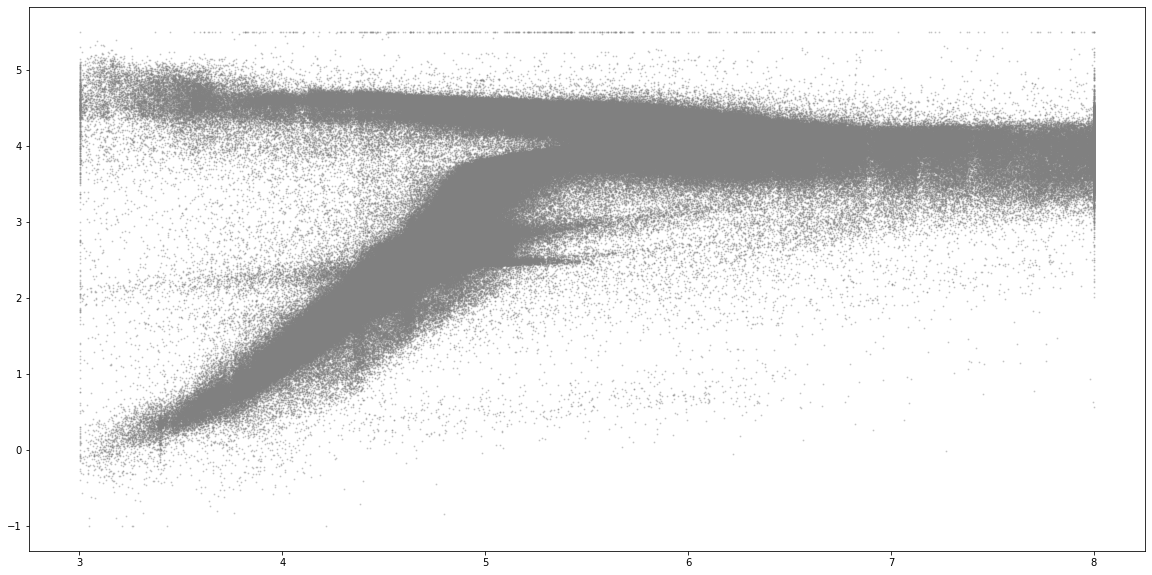

In [14]:
plt.figure(figsize=(20,10))
plt.scatter(GALAH_DR4['teff'].values / 1000, GALAH_DR4['logg'].values, c='gray', s=1, alpha=0.3)
plt.plot(model.param_data['teff_1'], model.param_data['logg_1'], '.', label='Component 1', ls='-', lw=1, c='orange', alpha=0.5)
plt.scatter(model.param_data['teff_1'][-1], model.param_data['logg_1'][-1], label='Component 1', s=350,  c='red', marker='x')
plt.scatter(model.param_data['teff_1'][0], model.param_data['logg_1'][0], label='Component 1', s=350,  c='red', marker='.')

plt.plot(model.param_data['teff_2'], model.param_data['logg_2'], 'o', label='Component 2', ls='-', lw=1)
plt.scatter(model.param_data['teff_2'][-1], model.param_data['logg_2'][-1], label='Component 1', s=350,  c='red', marker='x')
plt.scatter(model.param_data['teff_2'][0], model.param_data['logg_2'][0], label='Component 1', s=350,  c='red', marker='.')

plt.xlabel('teff 1')
plt.ylabel('logg 1' )
plt.ylim(-1, 5)
plt.xlim(3, 8)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()


plt.figure(figsize=(20,10))
x = np.arange(0, len(model.param_data['teff_1']))
plt.plot(x, model.param_data['teff_1'], 'o', label='Component 1 teff', ls='-', lw=1)
plt.plot(x, model.param_data['teff_2'], 'o', label='Component 2 teff', ls='-', lw=1)

plt.plot(x, model.param_data['logg_1'], 'o', label='Component 1 logg', ls='-', lw=1)
plt.plot(x, model.param_data['logg_2'], 'o', label='Component 2 logg', ls='-', lw=1)
plt.legend()

plt.figure(figsize=(20,10))
plt.plot(x, model.param_data['residual'], 'o', label='Component 1', ls='-', lw=1)

plt.figure(figsize=(20,10))
plt.plot(x, model.param_data['f_contr'], 'o', label='Component 1', ls='-', lw=1)



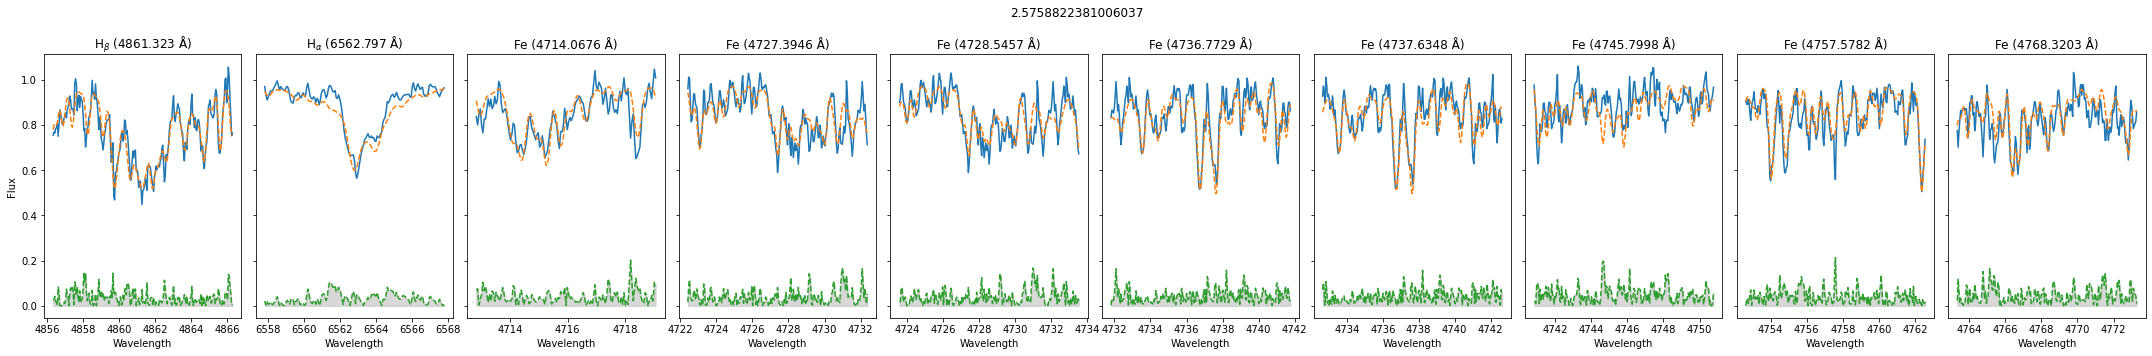

<Table length=15101>
       wave               sob         ...        smod         mob 
     float64            float64       ...      float64        bool
------------------ ------------------ ... ------------------ -----
 4712.807248783402 0.8377494798193145 ... 0.9081564299831242  True
 4712.853270574516 0.8005894656497954 ... 0.8761979950792974  True
 4712.899292365629 0.8473295663129368 ... 0.8515193698275472  True
 4712.945314156742 0.8717163316620767 ... 0.8422177229572496  True
 4712.991335947856 0.8001108438335998 ... 0.8500412280558998  True
 4713.037357738969 0.7655396790019225 ...  0.870041972747887  True
 4713.083379530082 0.8273962972643376 ... 0.8936049267051984  True
4713.1294013211955 0.8267750159678164 ... 0.9129577568931535  True
4713.1754231123095 0.8724902745062434 ... 0.9249173586648332  True
 4713.221444903422 0.9163271097782089 ... 0.9309986954473637  True
               ...                ... ...                ...   ...
 7884.591195401748 0.9846478259276189 ... 0.9881728401239489  True
 7884.664740499734  0.956912084959346 ... 0.9895947810262393  True
 7884.738285597719 0.9481407213957243 ... 0.9884991262145292  True
 7884.811830695705 0.9796450824239187 ... 0.9849432855811963  True
7884.8853757936895   0.97802263437115 ... 0.9794986909618244  True
 7884.958920891675  1.006258344965112 ... 0.9736694901856913  True
 7885.032465989661 1.0068053124664607 ... 0.9694990901250128  True
 7885.106011087647 1.0294041784317165 ...   0.96829939968855  True
7885.1795561856325 1.1048133131624416 ... 0.9703885236621161  True
 7885.253101283618  1.190953625769364 ... 0.9753735372724525 False

In [60]:

# Save spectrum
save_spectrum = Table()
save_spectrum['wave'] = wave_iter1
save_spectrum['sob'] = data_iter1
save_spectrum['uob'] = np.sqrt(sigma2_iter1)
save_spectrum['smod'] = model_iter1
save_spectrum['mob'] = unmasked_iter1

save_spectrum